In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split

from sandbox import (
    kosten_pro_diagnose,
    kosten_pro_eingriff,
    kosten_pro_medikament,
)

pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format

# Basics

In [2]:
df = pd.read_csv('data/DATENSATZ_UEAI.csv', delimiter=',')
df.tail()

,Versnr,Jahr,Ausgaben,Diagnose,Medikament,Eingriff,Gebjahr
145067,10000,2020,268.77,ICD10,NaN,NaN,1965
145068,10000,2021,261.39,ICD20,ATC-18,183+OPS,1965
145069,10000,2021,281.06,ICD09,ATC-11,113+OPS,1965
145070,10000,2021,643.26,ICD23,ATC-84,843+OPS,1965
145071,10000,2021,253.86,ICD26,NaN,NaN,1965


# Statistik

In [3]:
summary_stats = df.describe(include="all").round(2)
summary_stats.loc["nunique"] = df.nunique()  # number of unique values
summary_stats.loc["missing"] = df.isnull().sum()  # number of missing values
summary_stats

,Versnr,Jahr,Ausgaben,Diagnose,Medikament,Eingriff,Gebjahr
count,"145,072.00","145,072.00","145,072.00",130664,127194,115997,"145,072.00"
unique,NaN,NaN,NaN,86,109,109,NaN
top,NaN,NaN,NaN,ICD05,ATC-03,033+OPS,NaN
freq,NaN,NaN,NaN,3222,3102,2819,NaN
mean,"4,997.09","2,019.43",361.92,NaN,NaN,NaN,"1,965.64"
std,"2,888.94",1.13,327.29,NaN,NaN,NaN,12.32
min,1.00,"2,018.00",5.94,NaN,NaN,NaN,"1,919.00"
25%,"2,492.75","2,018.00",161.14,NaN,NaN,NaN,"1,957.00"
50%,"4,990.50","2,019.00",276.26,NaN,NaN,NaN,"1,966.00"
75%,"7,492.00","2,020.00",457.93,NaN,NaN,NaN,"1,974.00"



- Versnr ist der Identifyer
- Das Dataset geht über 4 Jahre
- Die Spalten Diagnosen, Medikament und Eingriff sind Pseudocodes und weisen Lücken auf
- Die Spalten Medikament und Eingriff haben vermutlich Korrelationen
- Die Versicherten scheinen gehobenen Alters zu sein.

# Verteilungen

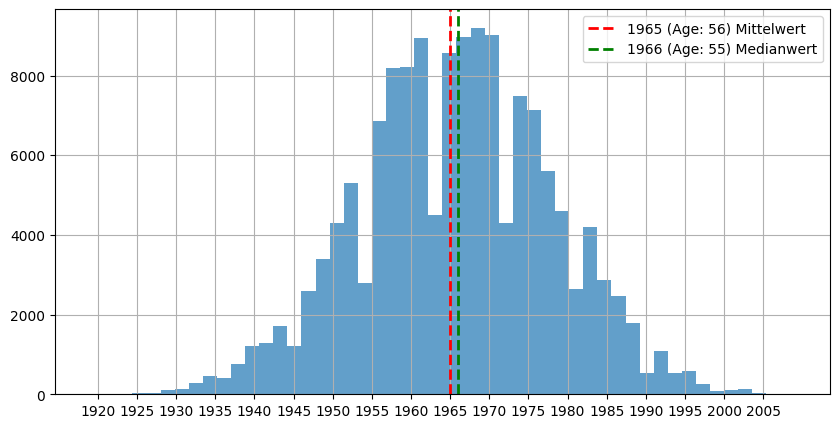

Jahre ohne Versicherten in Datatset: {1920, 1922, 1923, 2006, 2007, 2008}
Hypothese: die frühen Jahrgänge könnten bereits verstoben sein.
Hypothese: die frühen Jahrgänge könnten noch nicht beahndelt oder medikamentiert sein. Stark abhängig von der Auswahl der ICD-10 Codes.


In [4]:
# Histogramm
df["Gebjahr"].hist(figsize=(10, 5), bins=50, alpha=0.7)
mean_value = df["Gebjahr"].mean()
median_value = df["Gebjahr"].median()

# Remove decimal places from mean and median values
mean_value = int(mean_value)
median_value = int(median_value)

# Calculate age in years
current_year = df.Jahr.max() # 2021
mean_age = current_year - mean_value
median_age = current_year - median_value

# Update the plot with age information
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label=f'{mean_value} (Age: {mean_age}) Mittelwert')
plt.axvline(median_value, color='g', linestyle='dashed', linewidth=2, label=f'{median_value} (Age: {median_age}) Medianwert')
plt.legend()

# Set x-axis ticks in steps of 5 years
plt.xticks(range(df["Gebjahr"].min() + 1, df["Gebjahr"].max() + 1, 5))

plt.show()

df["Gebjahr"].value_counts().sort_index()
missing_years = set(range(df["Gebjahr"].min(), df["Gebjahr"].max())) - set(df["Gebjahr"].unique())
print("Jahre ohne Versicherten in Datatset:", missing_years)
print("Hypothese: die frühen Jahrgänge könnten bereits verstoben sein.")
print("Hypothese: die frühen Jahrgänge könnten noch nicht beahndelt oder medikamentiert sein. Stark abhängig von der Auswahl der ICD-10 Codes.")

# Cleaning

In [5]:
# Entfernen von Sonderzeichen und Buchstaben aus den Spalten Diagnose, Medikament und Eingriff
df['Diagnose'] = df['Diagnose'].str.replace(r'[^0-9]', '', regex=True).fillna("Missing")
df['Medikament'] = df['Medikament'].str.replace(r'[^0-9]', '', regex=True).fillna("Missing")
df['Eingriff'] = df['Eingriff'].str.replace(r'[^0-9]', '', regex=True).fillna("Missing")
df.head()

,Versnr,Jahr,Ausgaben,Diagnose,Medikament,Eingriff,Gebjahr
0,1,2018,720.08,37,66,663,1977
1,1,2018,408.20,97,00,003,1977
2,1,2018,85.79,49,50,503,1977
3,1,2018,132.53,Missing,13,Missing,1977
4,2,2018,32.47,04,32,323,1939


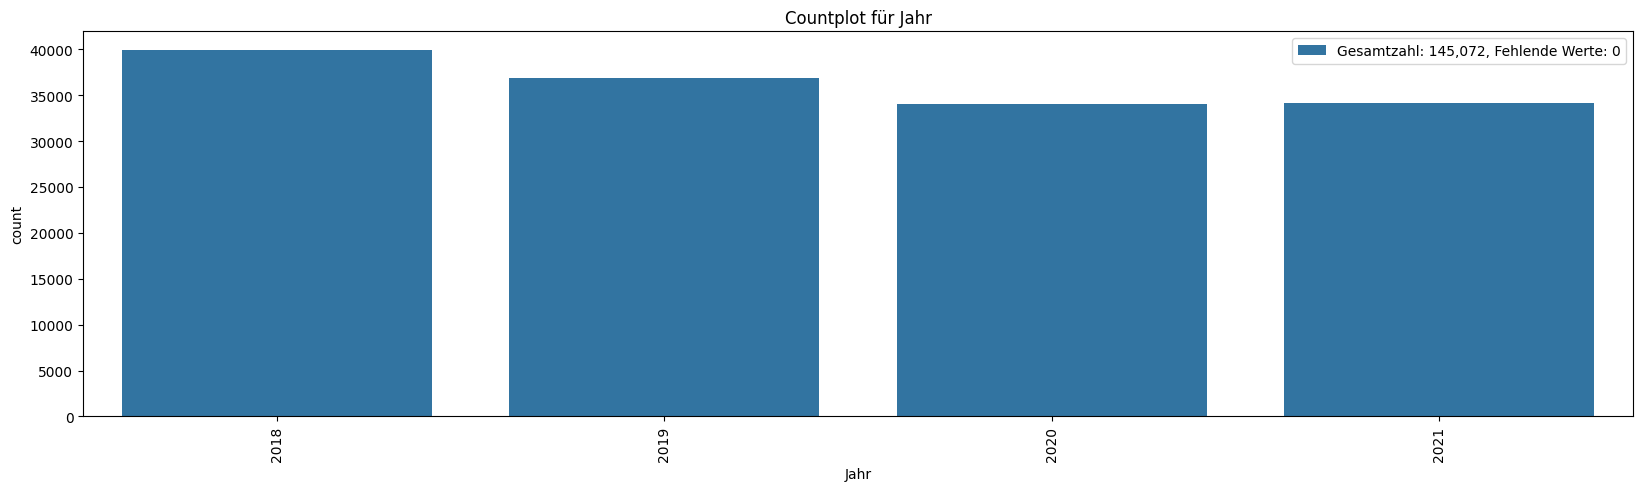

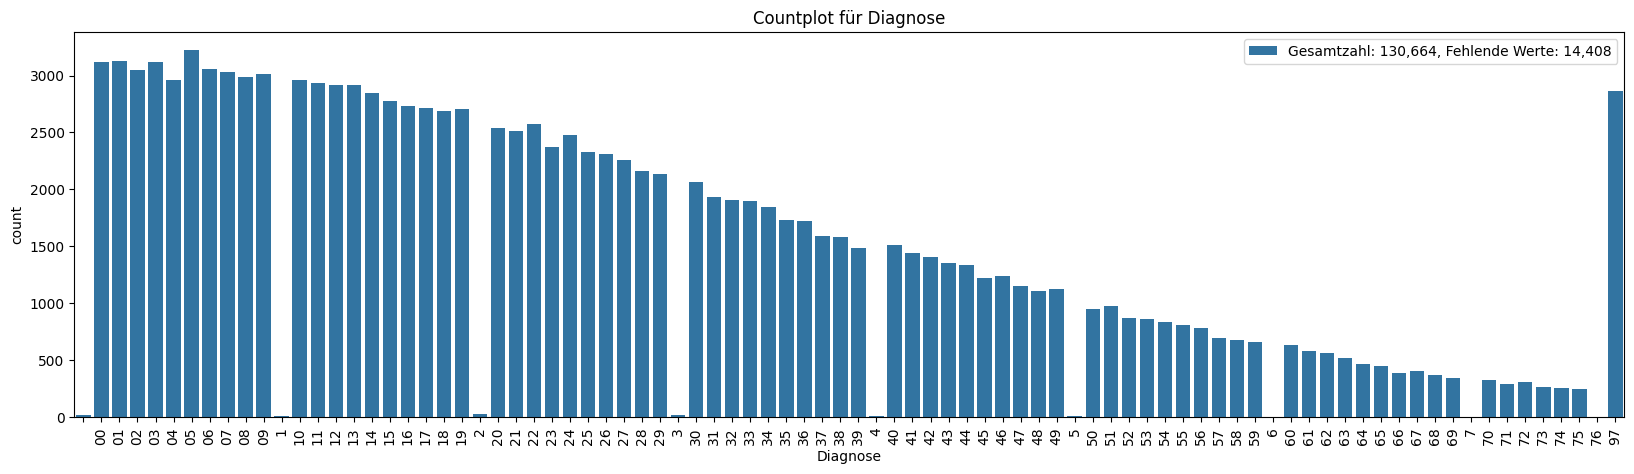

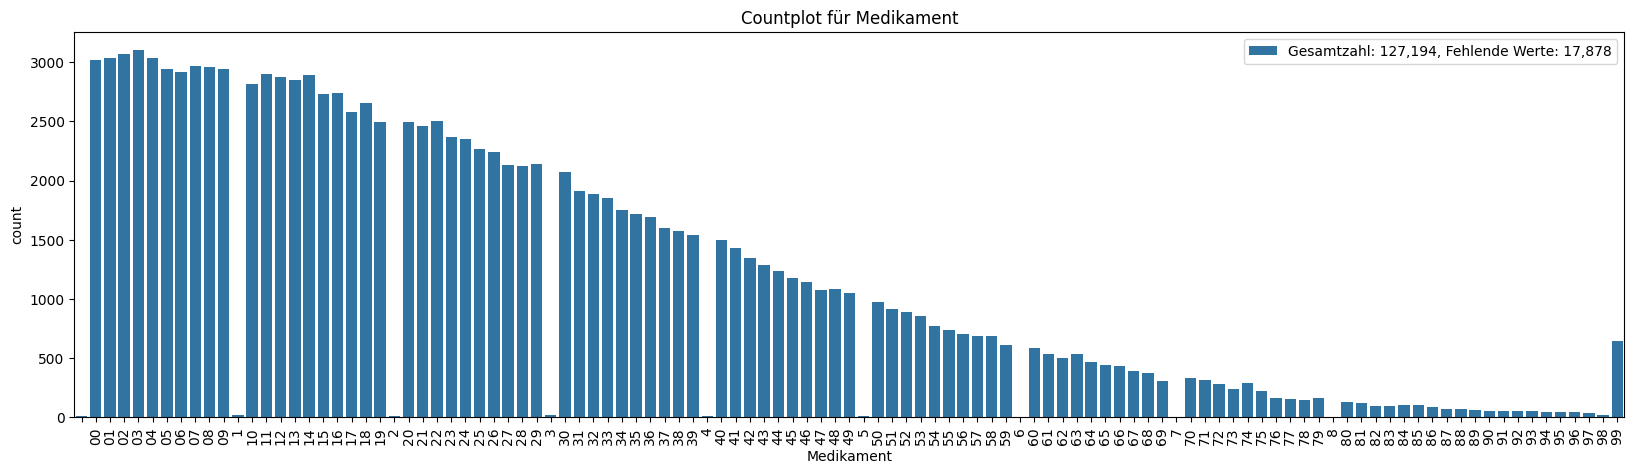

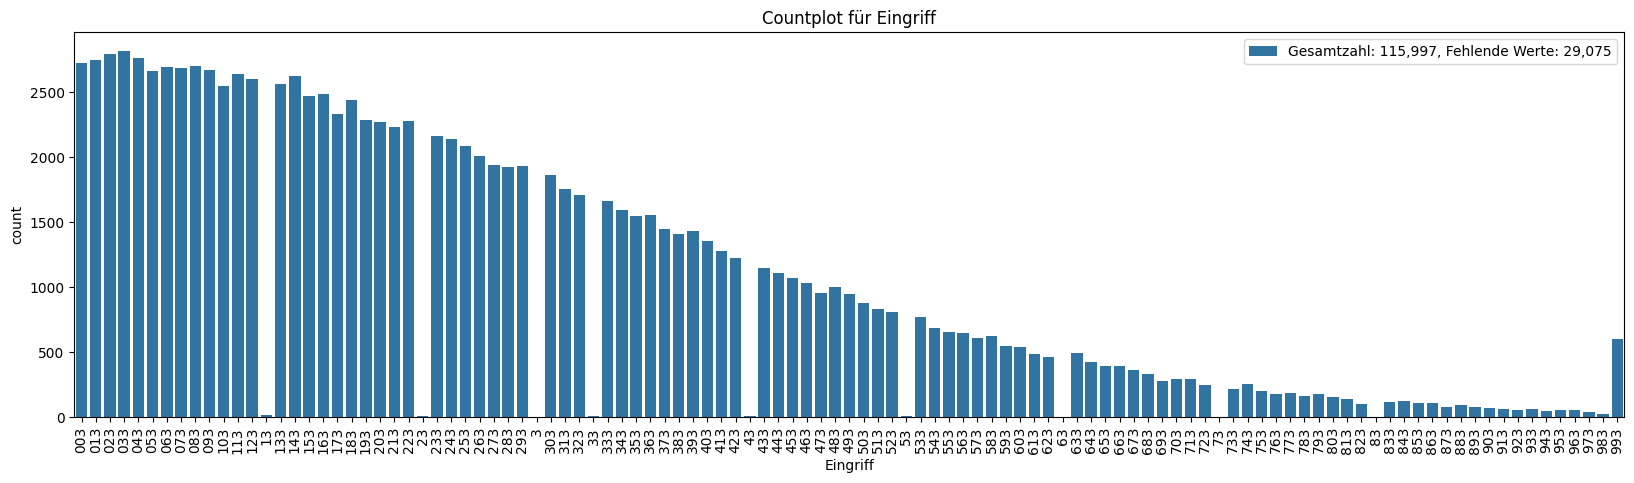

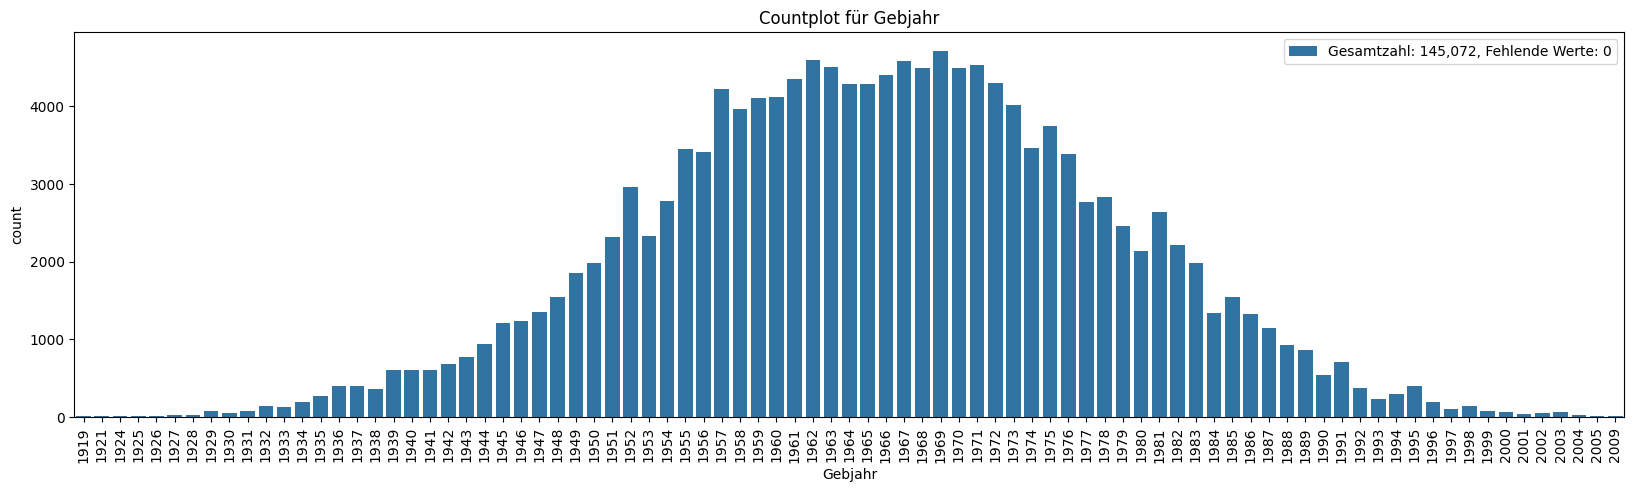

In [6]:
# Erstellen von Countplots für jede Spalte im DataFrame
for column in df.columns:
    if column in ["Versnr", "Ausgaben"]:
        continue
    plt.figure(figsize=(20, 5))
    filtered_df = df[df[column] != "Missing"]
    sorted_values = filtered_df[column].value_counts().sort_index()
    sns.countplot(data=filtered_df, x=column, order=sorted_values.index)
    total_count = filtered_df[column].count()
    nan_count = df[column].isnull().sum()
    missing_count = (df[column] == "Missing").sum()
    plt.title(f'Countplot für {column}')
    plt.xticks(rotation=90)
    plt.legend([f'Gesamtzahl: {total_count:,}, Fehlende Werte: {missing_count:,}'])
    plt.show()


# Kosten im Blick
## Diagnosen

In [7]:
diagnosen_stats = kosten_pro_diagnose(df, ['Diagnose'], ascending=False)
diagnosen_stats.head(10).sort_values(by='Durchschnittliche_Kosten_pro_Versicherten', ascending=False)

,Gesamtkosten,Anzahl_Diagnosen,Anzahl_Versicherte,Durchschnittliche_Kosten_pro_Diagnose,Durchschnittliche_Kosten_pro_Versicherten
Diagnose,,,,,
Missing,"5,242,322.84",14408,6768,363.85,774.57
97,"1,550,975.24",2863,2735,541.73,567.08
05,"1,118,955.60",3222,2768,347.29,404.25
09,"1,030,846.38",3011,2584,342.36,398.93
00,"1,071,327.01",3122,2689,343.15,398.41
03,"1,054,577.05",3122,2655,337.79,397.20
02,"1,023,790.70",3046,2630,336.11,389.27
08,"1,007,734.52",2984,2603,337.71,387.14
07,"1,009,079.30",3032,2618,332.81,385.44


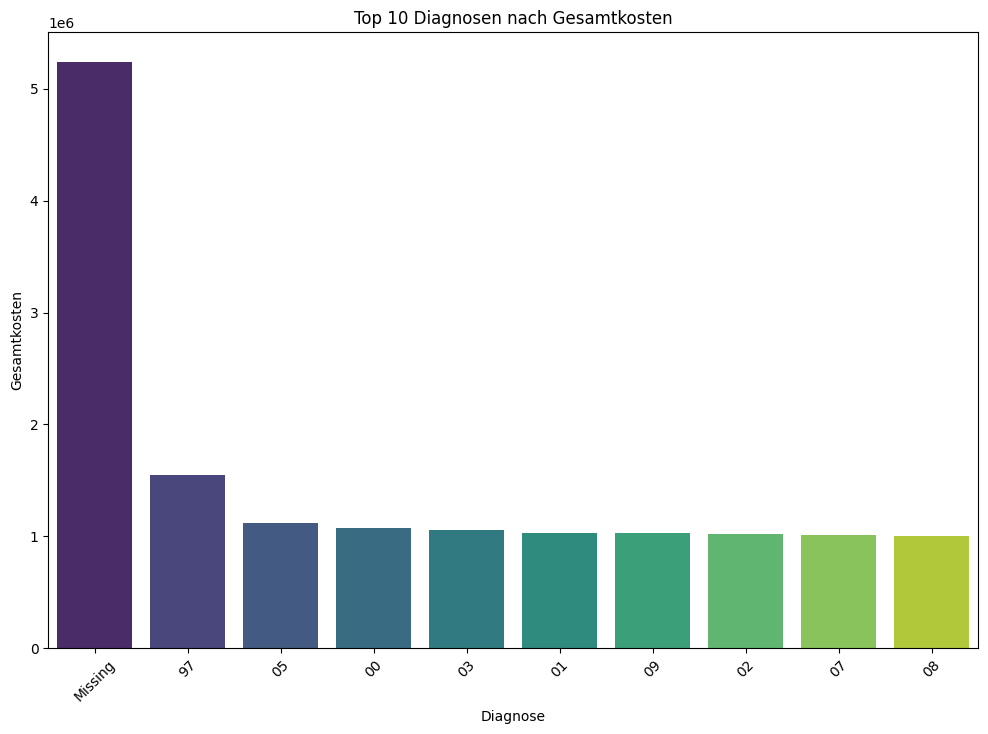

In [8]:
# Plotten der Top 10 Diagnosen basierend auf den Gesamtkosten
top_10 = diagnosen_stats.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10.index, y=top_10['Gesamtkosten'], hue=top_10.index, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Diagnosen nach Gesamtkosten')
plt.xlabel('Diagnose')
plt.ylabel('Gesamtkosten')
plt.xticks(rotation=45)
plt.show()

## Medikament

In [9]:
medikament_stats = kosten_pro_medikament(df, ['Medikament'], ascending=False)
medikament_stats.round(2).to_csv('data/medikament_stats.csv', index=False)
medikament_stats_year = kosten_pro_medikament(df, ['Jahr', 'Medikament'], ascending=False)
medikament_stats_year.head(20).sort_values(by='Jahr', ascending=False)

Gesamtkosten  Anzahl_Verschreibungen  Anzahl_Versicherte  \
Jahr Medikament                                                             
2021 Missing     1,789,957.97                    4155                4155   
     04            288,046.75                     720                 699   
     11            298,674.30                     722                 696   
     03            313,333.25                     768                 737   
     14            281,720.87                     685                 660   
     99            284,084.36                     329                 324   
     07            285,993.03                     728                 698   
     01            287,920.24                     698                 677   
     13            285,361.13                     689                 668   
     02            285,593.63                     713                 695   
     00            287,466.21                     702                 678   
2020 Missing     1,476,413.34                    4153                4153   
2019 06            298,226.15                     806                 786   
     Missing     1,671,248.89                    4596                4596   
     03            318,635.00                     820                 799   
     09            298,570.17                     775                 755   
     01            287,232.06                     800                 780   
     02            292,967.33                     759                 746   
     04            282,473.60                     775                 751   
2018 Missing     1,471,688.62                    4974                4974   

                 Durchschnittliche_Kosten_pro_Verschreibung  \
Jahr Medikament                                               
2021 Missing                                         430.80   
     04                                              400.06   
     11                                              413.68   
     03                                              407.99   
     14                                              411.27   
     99                                              863.48   
     07                                              392.85   
     01                                              412.49   
     13                                              414.17   
     02                                              400.55   
     00                                              409.50   
2020 Missing                                         355.51   
2019 06                                              370.01   
     Missing                                         363.63   
     03                                              388.58   
     09                                              385.25   
     01                                              359.04   
     02                                              385.99   
     04                                              364.48   
2018 Missing                                         295.88   

                 Durchschnittliche_Kosten_pro_Versicherten  
Jahr Medikament                                             
2021 Missing                                        430.80  
     04                                             412.08  
     11                                             429.13  
     03                                             425.15  
     14                                             426.85  
     99                                             876.80  
     07                                             409.73  
     01                                             425.29  
     13                                             427.19  
     02                                             410.93  
     00                                             423.99  
2020 Missing                                        355.51  
2019 06                                             379.42  
     Missing        

In [10]:
medikament_stats.describe()

,Gesamtkosten,Anzahl_Verschreibungen,Anzahl_Versicherte,Durchschnittliche_Kosten_pro_Verschreibung,Durchschnittliche_Kosten_pro_Versicherten
count,110.00,110.00,110.00,110.00,110.00
mean,"477,318.91","1,318.84","1,111.87",366.60,392.60
std,"685,362.84","1,924.98","1,138.23",65.39,80.67
min,646.83,1.00,1.00,161.81,161.81
25%,"45,046.20",133.50,131.25,350.31,382.52
50%,"334,462.90",812.00,778.00,361.75,396.75
75%,"802,092.52","2,216.25","1,998.25",384.60,406.75
max,"6,409,308.82","17,878.00","7,794.00",796.07,844.44


In [11]:
highest_avg_cost_per_prescription = medikament_stats_year['Durchschnittliche_Kosten_pro_Verschreibung'].idxmax()
highest_avg_cost_per_prescription, medikament_stats_year.loc[highest_avg_cost_per_prescription]

((np.int64(2021), '99'),
 Gesamtkosten                                 284,084.36
 Anzahl_Verschreibungen                           329.00
 Anzahl_Versicherte                               324.00
 Durchschnittliche_Kosten_pro_Verschreibung       863.48
 Durchschnittliche_Kosten_pro_Versicherten        876.80
 Name: (2021, 99), dtype: float64)

Beobachtungen:
- Das Medikament ATC-03 steigt zwischen den Jahren 2019 und 2021 um fast 30 € im Preis. Hier sollte man einen Blick drauf haben.

Allgemeine Kostentrends:
- Die Gesamtkosten variieren erheblich von 650 - 1,1 Mio €.
- Die Durchschnittliche_Kosten_pro_Verschreibung variieren erheblich, von etwa 160 € bis zu 800 €, was auf signifikante Unterschiede in den Verschreibungsmustern oder den Medikamentenpreisen hindeutet.

Kostenintensive Behandlungen:
- Die höchsten durchschnittlichen Kosten pro Verschreibung betragen 863,48 €, was auf besonders teure Medikamente oder Behandlungen hinweist.
- Es gibt mehrere Fälle, in denen die durchschnittlichen Kosten pro Verschreibung über 700 € liegen, was auf spezialisierte oder hochpreisige Therapien hindeutet.

Kosteneffizienz:
- Die durchschnittlichen Kosten pro Verschreibung liegen bei etwa 360 €, was möglicherweise auf günstigere Generika oder weniger komplexe Behandlungen zurückzuführen ist.
- Es gibt eine beträchtliche Spanne zwischen den höchsten und niedrigsten Durchschnittskosten, was Raum für Kostenoptimierung suggeriert. Vielleicht Verträge abschließen?


## Eingriff

In [12]:
eingriff_stats_year = kosten_pro_eingriff(df, ['Jahr', 'Eingriff'], ascending=False)
eingriff_stats = kosten_pro_eingriff(df, ['Eingriff'], ascending=False)
eingriff_stats_year.head(10)

Gesamtkosten  Anzahl_Eingriffe  Anzahl_Versicherte  \
Jahr Eingriff                                                       
2021 Missing   2,917,709.27              6832                6832   
2019 Missing   2,766,047.17              7397                7397   
2020 Missing   2,425,947.44              6831                6831   
2018 Missing   2,366,475.33              8015                8015   
2019 033         296,608.86               765                 746   
     063         282,348.60               748                 733   
2021 033         275,390.75               687                 668   
2019 093         272,789.79               712                 696   
     023         266,777.64               700                 692   
2021 113         265,375.85               648                 631   

               Durchschnittliche_Kosten_pro_Eingriff  \
Jahr Eingriff                                          
2021 Missing                                  427.07   
2019 Missing                                  373.94   
2020 Missing                                  355.14   
2018 Missing                                  295.26   
2019 033                                      387.72   
     063                                      377.47   
2021 033                                      400.86   
2019 093                                      383.13   
     023                                      381.11   
2021 113                                      409.53   

               Durchschnittliche_Kosten_pro_Versicherten  
Jahr Eingriff                                             
2021 Missing                                      427.07  
2019 Missing                                      373.94  
2020 Missing                                      355.14  
2018 Missing                                      295.26  
2019 033                                          397.60  
     063                                          385.20  
2021 033                                          412.26  
2019 093                                          391.94  
     023                                          385.52  
2021 113                                          420.56

# Zahl der Versicherten

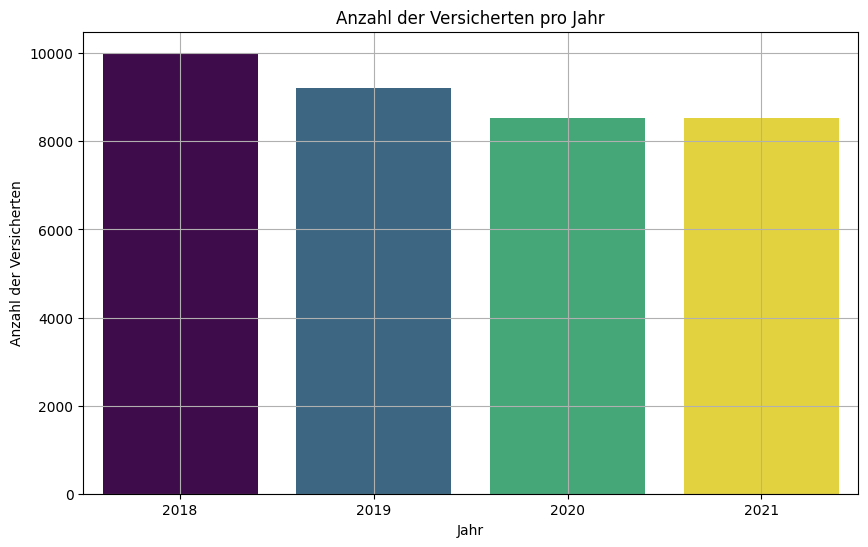

Jahr
2018    9990
2019    9222
2020    8526
2021    8530
Name: Versnr, dtype: int64

In [13]:
# Zähle die Anzahl der eindeutigen Versicherten pro Jahr
versnr_per_year = df.groupby('Jahr')['Versnr'].nunique()

# Plotten der Anzahl der Versicherten pro Jahr als Balkendiagramm
plt.figure(figsize=(10, 6))
sns.barplot(x=versnr_per_year.index, y=versnr_per_year.values, hue=versnr_per_year.index, palette='viridis', dodge=False, legend=False)
plt.title('Anzahl der Versicherten pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Versicherten')
plt.grid(True)
plt.show()

# Ausgabe der Anzahl der Versicherten pro Jahr
versnr_per_year

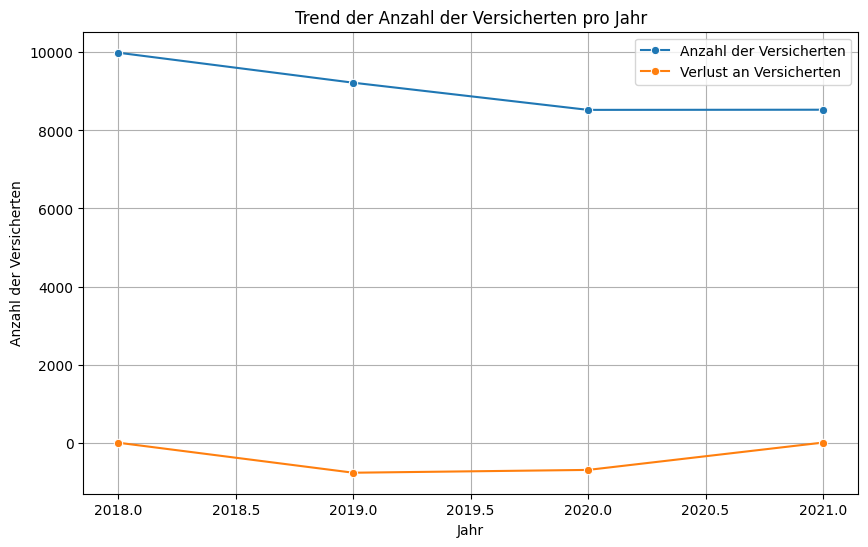

Jahr
2018      0
2019   -768
2020   -696
2021      4
Name: Versnr, dtype: int64

In [14]:
# Berechne den jährlichen Verlust an Versicherten
versnr_per_year_diff = versnr_per_year.diff().fillna(0).astype(int)

# Plotten des Trends der Anzahl der Versicherten pro Jahr
plt.figure(figsize=(10, 6))
sns.lineplot(x=versnr_per_year.index, y=versnr_per_year.values, marker='o', label='Anzahl der Versicherten')
sns.lineplot(x=versnr_per_year.index, y=versnr_per_year_diff.values, marker='o', label='Verlust an Versicherten')
plt.title('Trend der Anzahl der Versicherten pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Versicherten')
plt.legend()
plt.grid(True)
plt.show()

# Ausgabe der Anzahl der Versicherten pro Jahr und deren jährlicher Verlust
versnr_per_year
versnr_per_year_diff

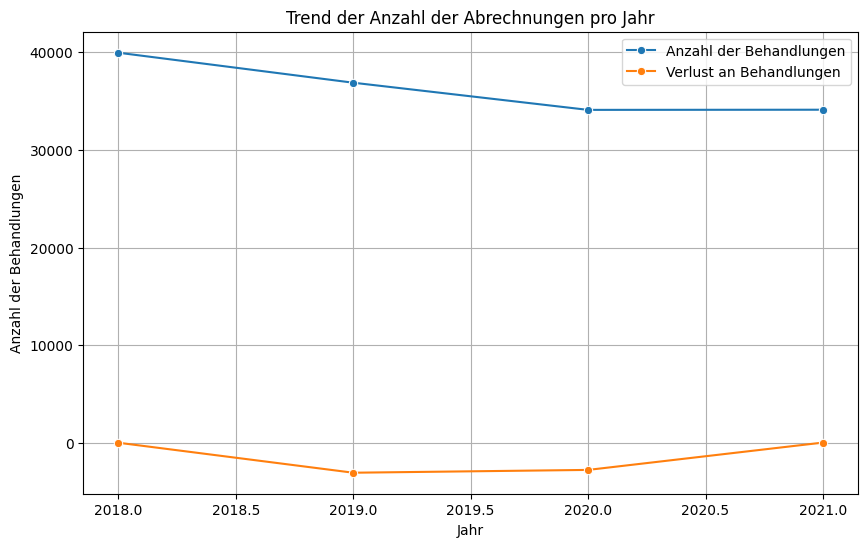

(Jahr
 2018    108
 2019    109
 2020    101
 2021    101
 Name: Medikament, dtype: int64,
 Jahr
 2018    108
 2019    109
 2020    101
 2021    101
 Name: Eingriff, dtype: int64,
 Jahr
 2018    86
 2019    86
 2020    78
 2021    78
 Name: Diagnose, dtype: int64)

In [15]:
# Zähle die Anzahl der Behandlungen pro Jahr
behandlungen_per_year = df.groupby('Jahr')['Eingriff'].count()

# Berechne den jährlichen Verlust an Behandlungen
behandlungen_per_year_diff = behandlungen_per_year.diff().fillna(0).astype(int)

# Plotten des Trends der Anzahl der Behandlungen pro Jahr
plt.figure(figsize=(10, 6))
sns.lineplot(x=behandlungen_per_year.index, y=behandlungen_per_year.values, marker='o', label='Anzahl der Behandlungen')
sns.lineplot(x=behandlungen_per_year.index, y=behandlungen_per_year_diff.values, marker='o', label='Verlust an Behandlungen')
plt.title('Trend der Anzahl der Abrechnungen pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Behandlungen')
plt.legend()
plt.grid(True)
plt.show()

# Ausgabe der Anzahl der Behandlungen pro Jahr und deren jährlicher Verlust
behandlungen_per_year
behandlungen_per_year_diff

# Zähle die Anzahl der Verschreibungen pro Jahr
medikament_per_year = df.groupby('Jahr')['Medikament'].nunique()

# Zähle die Anzahl der Eingriffe pro Jahr
eingriff_per_year = df.groupby('Jahr')['Eingriff'].nunique()

# Zähle die Anzahl der Diagnosen pro Jahr
diagnose_per_year = df.groupby('Jahr')['Diagnose'].nunique()

# Ausgabe der Anzahl der Verschreibungen, Eingriffe und Diagnosen pro Jahr
medikament_per_year, eingriff_per_year, diagnose_per_year

# Kosten der Versicherten

In [16]:
# Berechne die Summe der Ausgaben pro Jahr
ausgaben_pro_jahr = df.groupby('Jahr')['Ausgaben'].sum()

# Berechne die relative Steigerung im Vergleich zu 2018
ausgaben_2018 = ausgaben_pro_jahr.loc[2018]
relative_steigerung = ((ausgaben_pro_jahr - ausgaben_2018) / ausgaben_2018) * 100

# Ausgabe der Summe der Ausgaben pro Jahr und der relativen Steigerung
print("Summe der Ausgaben pro Jahr:\n", ausgaben_pro_jahr)
print("\nRelative Steigerung im Vergleich zu 2018 (%):\n", relative_steigerung)

Summe der Ausgaben pro Jahr:
 Jahr
2018   12,009,944.97
2019   13,517,283.91
2020   12,199,564.91
2021   14,778,286.41
Name: Ausgaben, dtype: float64

Relative Steigerung im Vergleich zu 2018 (%):
 Jahr
2018    0.00
2019   12.55
2020    1.58
2021   23.05
Name: Ausgaben, dtype: float64


# Gibt es Fälle mit gleichem Eingriff und gleicher Medikation, bei denen sich die Kosten untercheiden? - Betteridges Gesetz der Überschriften - Nein

In [17]:
crosstab = pd.crosstab(df['Medikament'], df['Eingriff'])

# Filtern der Einträge, bei denen die Häufigkeit mind. 1 ist
consistent_pairs = crosstab[crosstab == 1].stack().reset_index()
consistent_pairs.columns = ['Medikament', 'Eingriff', 'Count']
consistent_pairs['Haeufigkeit'] = consistent_pairs['Count']

# Filter the entries where the Haeufigkeit is greater than 1
consistent_pairs = consistent_pairs[consistent_pairs['Count'] >= 1]

print("Medikamente, die immer mit demselben Eingriff zusammenkommen:")
consistent_pairs[['Medikament', 'Eingriff', 'Haeufigkeit']].sort_values(by='Haeufigkeit', ascending=False).head()

Medikamente, die immer mit demselben Eingriff zusammenkommen:


,Medikament,Eingriff,Haeufigkeit
0,2,Missing,1.00
1,4,Missing,1.00
2,5,Missing,1.00
3,58,993,1.00
4,62,993,1.00


In [18]:
crosstab = pd.crosstab([df['Diagnose'], df['Medikament']], df['Eingriff'])

# Filtern der Einträge, bei denen die Häufigkeit mind. 1 ist
consistent_pairs = crosstab[crosstab == 1].stack().reset_index()
consistent_pairs.columns = ['Diagnose', 'Medikament', 'Eingriff', 'Count']
consistent_pairs['Haeufigkeit'] = consistent_pairs['Count']

# Filter the entries where the Haeufigkeit is greater than 1
consistent_pairs = consistent_pairs[consistent_pairs['Count'] >= 1]

print("Diagnosen, Medikamente und Eingriffe, die immer zusammen vorkommen:")
consistent_pairs[['Diagnose', 'Medikament', 'Eingriff', 'Haeufigkeit']].sort_values(by='Haeufigkeit', ascending=False).head()

Diagnosen, Medikamente und Eingriffe, die immer zusammen vorkommen:


,Diagnose,Medikament,Eingriff,Haeufigkeit
3920,Missing,Missing,933,1.00
3904,Missing,99,783,1.00
3903,Missing,99,193,1.00
3902,Missing,98,Missing,1.00
3901,Missing,92,Missing,1.00


# Regression zur Kostenvorhersage

In [19]:
# Wähle die relevanten Features und das Ziel
features = ['Diagnose', 'Medikament', 'Eingriff', 'Gebjahr']
target = 'Ausgaben'

# Entferne Zeilen mit fehlenden Werten in den relevanten Spalten
df_clean = df.dropna(subset=features + [target]).copy()

# Factorize string columns
for col in ['Diagnose', 'Medikament', 'Eingriff']:
    df_clean[col] = pd.factorize(df_clean[col])[0]

# Splitte die Daten in Trainings- und Testdaten
X = df_clean[features]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Berechne die Metriken
mse = root_mean_squared_error(y_test, y_pred)

print(f'Root Mean Squared Error: {mse:.2f} €')

Root Mean Squared Error: 325.88 €
